# Implementation of Models

In this notebook we will implement a bunch of models that will predict if a person has diabetes or not. This said, we will need a lot of libraries!

In [1]:
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier

/Applications/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data Processing

Now we will import the typical `diabetes data set`:

In [2]:
diabetes = pd.read_csv('diabetes-dataset.csv')
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0
...,...,...,...,...,...,...,...,...,...
1995,2,75,64,24,55,29.7,0.370,33,0
1996,8,179,72,42,130,32.7,0.719,36,1
1997,6,85,78,0,0,31.2,0.382,42,0
1998,0,129,110,46,130,67.1,0.319,26,1


Let us inspect this data set a bit. In particular, let us take a deeper look into the `Pregnancies` variable:

In [ ]:
diabetes['Pregnancies'].value_counts()

So we have three women that have had 17 pregnancies! Is not that a little odd? Let us take a peek into this:

In [27]:
diabetes[diabetes['Pregnancies'] == 17]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
159,17,163.0,72.0,41.0,114.0,40.9,0.817,47,1
1317,17,163.0,72.0,41.0,114.0,40.9,0.817,47,1
1980,17,163.0,72.0,41.0,114.0,40.9,0.817,47,1


These three women are actually the same person! It seems that we have observations that are redundant. To get rid of these duplicates we can use the `drop_duplicates` method:

In [ ]:
diabetes = diabetes.drop_duplicates()
diabetes

As we can see we had lots of duplicates. It is kind of inconvenient since this reduced the size of our dataset quite a bit. Anyhoo, life is like that sometimes. 

## Dealing with Missing Data

In a previous episode, we noticed that there are a lot of missing values that were replaced by zeros. In some cases it is convenient to replace those values by an estimation of what should be in their place. There are several options for this, for instance, replacing those `NaNs` with zeros, however, we can better than that: another option is to use **regression** for estimating those values that are not with us anymore. Having this said, how many zeros we have per variable?

In [3]:
diabetes.replace([0], np.nan).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               1699 non-null   float64
 1   Glucose                   1987 non-null   float64
 2   BloodPressure             1910 non-null   float64
 3   SkinThickness             1427 non-null   float64
 4   Insulin                   1044 non-null   float64
 5   BMI                       1972 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   684 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 140.8 KB


As you can see, the variable `Insulin` has a lot of zeros. What variables could be useful for estimating the missing insulin numbers? A correlation matrix can give us some hints.

Text(0.5, 1.0, 'Correlation matrix for the diabetes dataset')

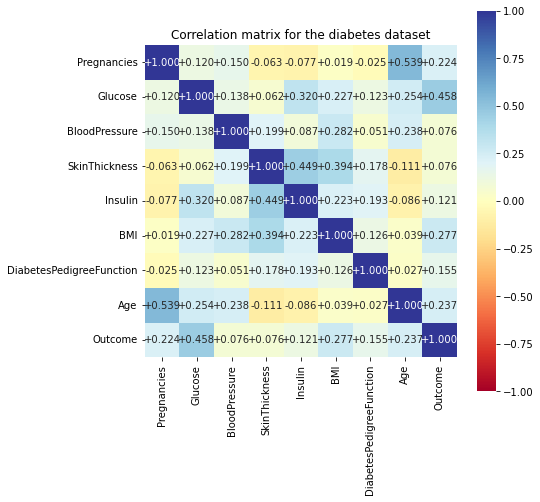

In [4]:
plt.figure(figsize=(7,7))
sns.heatmap(diabetes.corr(), cmap="RdYlBu", 
    annot=True, square=True,
    vmin=-1, vmax=1, fmt="+.3f")
plt.title("Correlation matrix for the diabetes dataset")

Since several variables have many zeros, we can estimate the missing numbers by employing some model capable of doing regression. In this case, we will use **k-Nearest Neighbors**. Nevertheless, we are not interested in replacing the zeros of either `Pregnancies` and `Outcome`, but for variables such as `Glucose` this could be useful. 

What we will have to do is that for each variable that has zeros, we will use the other variables as predictors, employ only observations that have no missing data, and train a `kNN` model to estimate the missing values. As you can imagine, we will have to repeat this process several times.

In [5]:
no_glucose = ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
no_bloodpressure = ['Glucose', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
no_skin = ['Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
no_insulin = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Age']
no_bmi = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']

In [6]:
predictors_set = [no_glucose, no_bloodpressure, no_skin, no_insulin, no_bmi]
objectives = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
k = 5

for predictors, objective in zip(predictors_set, objectives):
    X = diabetes[diabetes[predictors].isin([0]).any(axis=1).apply(lambda x: not x)]
    y = X[objective]
    X = X.drop(columns=objective)
    kNN_model = KNeighborsRegressor(n_neighbors=k).fit(X,y)
    X_hat = diabetes[diabetes[objective] == 0].drop(columns=objective)
    diabetes[objective][diabetes[objective] == 0] = kNN_model.predict(X_hat)

diabetes.describe()

/var/folders/2f/r2wrcrpx3c5c2k7lgfc9jsmm0000gp/T/ipykernel_26578/2746939200.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes[objective][diabetes[objective] == 0] = kNN_model.predict(X_hat)
/var/folders/2f/r2wrcrpx3c5c2k7lgfc9jsmm0000gp/T/ipykernel_26578/2746939200.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes[objective][diabetes[objective] == 0] = kNN_model.predict(X_hat)
/var/folders/2f/r2wrcrpx3c5c2k7lgfc9jsmm0000gp/T/ipykernel_26578/2746939200.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.776800,72.275900,29.642200,93.556200,32.466810,0.470930,33.090500,0.342000
std,3.306063,30.674141,12.247252,10.103913,107.724019,7.425519,0.323553,11.786423,0.474498
min,0.000000,44.000000,24.000000,7.000000,0.000000,3.900000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,24.000000,0.000000,27.400000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.200000,65.800000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,35.000000,140.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


## Training and Testing sets

As usual, we need to create our training and testing datasets. First, we will create a `dataframe` that will contain only the predictors and a `series` for our labels.

In [7]:
X = diabetes
y = X['Outcome']
X = X.drop(columns='Outcome')

For improving the convergence of the models during their training it is recommended to normalize our data so that the magnitudes of all of our variables are roughly the same. This is done in the following cell.

In [8]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

And now we can create our `train set` and the `test set`.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Implementing the Models

Now we implement a bunch of models. We will start with the simple and intuitive model known as **Decision Trees**. This model can do both regression and classification, but we will use them for doing classification.

In [10]:
tree_model = tree.DecisionTreeClassifier().fit(X_train,y_train)
y_pred_tree = tree_model.predict(X_test)

One of the disadvantages of Decission Trees is that tend to overfit the data. One model that overcomes this is the **Random Forest**, which in a few words is a bunch of trees that are built in a random fashion. The predictions done by each of the trees of the random forest are *averaged* to come up with a prediction.

In [11]:
random_model = RandomForestClassifier().fit(X_train,y_train)
y_pred_rand = random_model.predict(X_test)

The `XGB Classifier`, also known as `XGBoost`, is the **Extreme** version of **Gradient Boosting**, or in other words, an implementation of Gradient Boosting. Very briefly, Gradient Boosting is a collection of weak Decision Trees that are aggregated to produce a powerful model. In fact, `XGBoost` dominate in many **Kaggle Competitions**. 

In [12]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error').fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

A classic model in machine learning is **Support Vector Machine**. This model finds the best hyperplanes that create the biggest separation between observations that belong to different categories. Furthermore, it has a trick under its sleeve known as the **kernel trick** that allows us to work with decision boundaries more complex than a hyperplane.

In [13]:
svm_model = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

Finally, another classic of machine learning is **Logistic Regression**. Despite its name has the word regression in it, this model is used for classification purposes only. In its simple version it is used for binary classification, but it can be extended for multiple classification. It works well if classes are linearly separable. 

In [14]:
logistic_model = LogisticRegression().fit(X_train, y_train)
y_pred_log = logistic_model.predict(X_test)

## Evaluating Classification Models

So we have implemented several models, but which is the winner, or in other words, the best model for our data? To answer this question we need **evaluation metrics**. There are tons of metrics, and the ideal metric, or metrics, will have to be chosen depending on what is important for our particular application. For now, we will mention a few of the most common, however, before going any further, we need to say a few things about the **confusion matrix**.

#### Confusion Matrix

A confusion matrix is a table that allows us to visualize the performance of a classification algorithm. 

<img src="confusion.png" alt="Drawing" style="width: 600px;"/>

This type of table receives this name because it lets us observe whether an algorithm is mislabeling two classes (Image taken from https://en.wikipedia.org/wiki/Precision_and_recall). 

#### Accuracy

Accuracy is defined as follows:

$$
\text{Accuracy}=\frac{\text{true positives} + \text{true negatives}}{\text{true positives} + \text{false positives} +  \text{true negatives} + \text{false negatives}}.
$$

This metric is useful when both classes are equally important and when we have balanced sets, which is not always the case.

#### Precision

The ratio of positive cases that were correctly labeled over all the examples that were classified as positive is called **precision**:

$$
\text{Precision}=\frac{\text{true positives}}{\text{true positives} + \text{false positives}}.
$$

When we are interested in reducing the amount of false positives and we have imbalanced sets, precision is a good choice as an evaluation metric. Say we want to detect if an email is spam or not, then this metric is appriopriate if *spam* is the positive category: if a regular email is classified as spam (false positive), we are sending emails that are important for us to the spam folder; however, if a spam email is labeled as not-spam, said email will end up in our inbox, which is not as serious as not reading an email that we are expecting. 

#### Recall

Recall is the ratio of the examples that were correclty identified as a positive case over all the true positives examples in our data. This metric can be understood as the sensitivity of our model:

$$
\text{Recall}=\frac{\text{true positives}}{\text{true positives} + \text{false negatives}}.
$$

If we want to pay special attention to the false negatives that our model is detecting, and if our sets are imbalanced, then this can be one of our performance metrics. Suppose we want to build a model that detects a dangerous disease. In this case, we are not interested in telling a person that he/she does not have the disease when that is not the case (false negative). 

#### F1 Score

The F1 score is equal to the harmonic mean of precision and recall. It is useful when we want to have a balance between precision and recall and when we do not have balanced sets (large number of actual negatives). It is defined as 

$$
\text{F1 Score}=2\frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}.
$$

The following functions will help us to evaluate our models.

In [15]:
def concat_test_pred(y_test, y_pred):
    
    df_test = y_test.to_frame(name='Diabetes').reset_index().drop(columns='index')
    df_pred = pd.Series(y_pred).to_frame(name='Prediction')
    results = pd.concat([df_test, df_pred], axis=1)
    
    return results

In [16]:
def performance_metrics(results):
    
    positives = results[['Diabetes', 'Prediction']][results['Diabetes'] == 1]
    negatives = results[['Diabetes', 'Prediction']][results['Diabetes'] == 0]
    
    true_negatives = negatives[negatives['Diabetes'] == negatives['Prediction']].shape[0]
    false_positives = negatives[negatives['Diabetes'] != negatives['Prediction']].shape[0]
    true_positives = positives[positives['Diabetes'] == positives['Prediction']].shape[0]
    false_negatives = positives[positives['Diabetes'] != positives['Prediction']].shape[0]
    
    confusion_matrix = {'actual positives' : [true_positives, false_negatives], 
                        'actual negatives' : [false_positives, true_negatives]}
    
    confusion_matrix_df = pd.DataFrame.from_dict(confusion_matrix, orient='index', 
                                                 columns=['predicted positives', 'predicted negatives'])
    
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives +  true_negatives + false_negatives)
    precission = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precission * recall) / (precission + recall)
    
    metrics = {'Accuracy' : accuracy, 'Precission' : precission, 'Recall' : recall, 'F1 Score' : f1_score}
    
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Metrics'])
    
    return confusion_matrix_df, metrics_df  

In [17]:
results = concat_test_pred(y_test, y_pred_tree)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,193,10
actual negatives,12,385


In [18]:
metrics

,Metrics
Accuracy,0.963333
Precission,0.941463
Recall,0.950739
F1 Score,0.946078


In [19]:
results = concat_test_pred(y_test, y_pred_svm)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,125,78
actual negatives,28,369


In [20]:
metrics

,Metrics
Accuracy,0.823333
Precission,0.816993
Recall,0.615764
F1 Score,0.702247


In [21]:
results = concat_test_pred(y_test, y_pred_rand)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,190,13
actual negatives,4,393


In [22]:
metrics

,Metrics
Accuracy,0.971667
Precission,0.979381
Recall,0.935961
F1 Score,0.957179


In [23]:
results = concat_test_pred(y_test, y_pred_log)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,114,89
actual negatives,43,354


In [24]:
metrics

,Metrics
Accuracy,0.780000
Precission,0.726115
Recall,0.561576
F1 Score,0.633333


In [25]:
results = concat_test_pred(y_test, y_pred_xgb)
confusion_matrix, metrics = performance_metrics(results)
confusion_matrix

,predicted positives,predicted negatives
actual positives,192,11
actual negatives,9,388


In [26]:
metrics

,Metrics
Accuracy,0.966667
Precission,0.955224
Recall,0.945813
F1 Score,0.950495
